__Import libraries__

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance
from math import ceil


Helper functions

In [2]:
def create_date_features(df):
    
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    #df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.weekofyear
  
    

    def week_of_month(dt):
        """ Returns the week of the month for the specified date.
        """

        first_day = dt.replace(day=1)

        dom = dt.day
        adjusted_dom = dom + first_day.weekday()

        return int(ceil(adjusted_dom/7.0))
    
    df['weekofmonth'] = df['Date'].apply(week_of_month)
    
    return df

In [3]:
def till_func(x,holiday_dates):
    return min([diff for diff in (x-holiday_dates).days if diff>=0],default=-1)//7

def since_func(x,holiday_dates):
    return abs(max([diff for diff in (x-holiday_dates).days if diff<=0],default=-1)//7)


def add_since_till_holiday_feature(df,feature_name,holiday_dates,till_since_func,date_column='Date'):
    data = df.copy()
    data = data.assign(new_col=data['Date'].apply(till_since_func,args=(holiday_dates,)))
    data.rename(columns = {'new_col':feature_name},inplace=True)
    return data

In [4]:
def one_hot_encoding(train,test,cat_features):
    ohe = OneHotEncoder()
    
    ohe_train = ohe.fit_transform(train[cat_features]).toarray()
    ohe_train = pd.DataFrame(ohe_train,columns=ohe.get_feature_names())
    train.drop(cat_features,axis=1,inplace=True)
    train.reset_index(drop=True,inplace=True)
    train = pd.concat([train,ohe_train],axis=1)
    
    ohe_test = ohe.transform(test[cat_features]).toarray()
    ohe_test = pd.DataFrame(ohe_test,columns=ohe.get_feature_names())
    test.drop(cat_features,axis=1,inplace=True)
    test.reset_index(drop=True,inplace=True)
    test = pd.concat([test,ohe_test],axis=1)
    
    return (train,test)

In [9]:
def imputing(train,test,num_features):
    imputer = SimpleImputer(strategy='constant',fill_value=0)

    imp_train = pd.DataFrame(imputer.fit_transform(train[num_features]),columns=num_features)
    train[num_features] = imp_train
    
    imp_test = pd.DataFrame(imputer.transform(test[num_features]),columns=num_features)
    test[num_features] = imp_test
    
    return train,test

In [10]:
def get_store(data,store=None,dept=None):
    
    if ((store == None) & (dept == None)):
        print('Enter something atleast')
    
    if (dept == None):
        return data[(data.Store==store)]
    
    if (store == None):
        return data[(data.Dept==dept)]
    
    else:
        return data[(data.Store==store)&(data.Dept==dept)]

In [11]:
def custom_loss_scorer(estimator,X,y):
    weight_array = np.where(X.IsHoliday==True,5,1)
    preds = estimator.predict(X)
    error = np.mean(weight_array*np.abs(y-preds))
    
    return -(error)

__Import Data__

In [12]:
features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv',parse_dates=[1])
stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv',parse_dates=[2])
train = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv',parse_dates=[2])

__Merge data into 1 DataFrame__

In [13]:
train_data = pd.merge(left=pd.merge(left=train,right=stores,how='left'),right=features,how='left',on=['Store','Date','IsHoliday'])
test_data = pd.merge(left = pd.merge(left=test,right=stores,how='left'),right=features,how='left',on = ['Store','Date','IsHoliday'])

__Add Features__

In [14]:
train_data['CPI_cat'] = np.where(train_data.CPI<160,'LowCPI','HighCPI')
test_data['CPI_cat'] = np.where(test_data.CPI<160,'LowCPI','HighCPI')

train_data['Size_cat'] = np.where(train_data.Size<75000,'Small_Size',np.where(train_data.Size<175000,'Mid_Size','High_Size'))
test_data['Size_cat'] = np.where(test_data.Size<75000,'Small_Size',np.where(test_data.Size<175000,'Mid_Size','High_Size'))

In [15]:
sb_dates = pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
labor_dates = pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
thanksgiving_dates = pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
christmas_dates = pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])



train_data['Which_Holiday'] = 'NoHoliday'
train_data.loc[(np.isin(train_data[['Date']].values, sb_dates.values).reshape(-1)),'Which_Holiday'] = 'Super_Bowl'
train_data.loc[(np.isin(train_data[['Date']].values, labor_dates.values).reshape(-1)),'Which_Holiday'] = 'Labor_Day'
train_data.loc[(np.isin(train_data[['Date']].values, thanksgiving_dates.values).reshape(-1)),'Which_Holiday'] = 'Thanksgiving'
train_data.loc[(np.isin(train_data[['Date']].values, christmas_dates.values).reshape(-1)),'Which_Holiday'] = 'Christmas'

test_data['Which_Holiday'] = 'NoHoliday'
test_data.loc[(np.isin(test_data[['Date']].values, sb_dates.values).reshape(-1)),'Which_Holiday'] = 'Super_Bowl'
test_data.loc[(np.isin(test_data[['Date']].values, labor_dates.values).reshape(-1)),'Which_Holiday'] = 'Labor_Day'
test_data.loc[(np.isin(test_data[['Date']].values, thanksgiving_dates.values).reshape(-1)),'Which_Holiday'] = 'Thanksgiving'
test_data.loc[(np.isin(test_data[['Date']].values, christmas_dates.values).reshape(-1)),'Which_Holiday'] = 'Christmas'


__Create data for log scaled target__

In [16]:
train_log = train_data[train_data.Weekly_Sales>0]
train_log.loc[:,'Weekly_Sales_log'] = np.log(train_log.Weekly_Sales)

C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


__Seperate targets__

In [17]:
weekly_sales = train_data.Weekly_Sales
weekly_sales_log = train_log.Weekly_Sales_log
weekly_sales_log_org = train_log.Weekly_Sales

train_data.drop('Weekly_Sales',axis=1,inplace=True)
train_log.drop(['Weekly_Sales_log','Weekly_Sales'],axis=1,inplace=True)


C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
sb_dates = pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
labor_dates = pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
thanksgiving_dates = pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
christmas_dates = pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])

holiday_dates = sb_dates.append(labor_dates).append(thanksgiving_dates).append(christmas_dates)

In [19]:
all_holiday_dates = [holiday_dates,sb_dates,labor_dates,thanksgiving_dates,christmas_dates]
till_feature_names = ['WeeksTillNextHoliday','WeeksTillNextSuperBowl','WeeksTillLaborDay','WeeksTillNextThanksgiving','WeeksTillNextChristmas']
since_feature_names = ['WeeksSinceLastHoliday','WeeksSinceLastSuperBowl','WeeksSinceLastLaborDay','WeeksSinceLastThanksgiving','WeeksSinceLastChristmas']                     

In [16]:
for till_feature,since_feature,dates in (zip(till_feature_names,since_feature_names,all_holiday_dates)):
    
    train_data[till_feature] = train_data.Date.apply(till_func,args = (dates,))
    test_data[till_feature] = test_data.Date.apply(till_func,args = (dates,))
    print("Completed till feature " + till_feature)
    
    train_data[since_feature] = train_data.Date.apply(since_func,args = (dates,))
    test_data[since_feature] = test_data.Date.apply(since_func,args = (dates,))
    print("Completed since feature " + since_feature)

Completed till feature WeeksTillNextHoliday
Completed since feature WeeksSinceLastHoliday
Completed till feature WeeksTillNextSuperBowl
Completed since feature WeeksSinceLastSuperBowl
Completed till feature WeeksTillLaborDay
Completed since feature WeeksSinceLastLaborDay
Completed till feature WeeksTillNextThanksgiving
Completed since feature WeeksSinceLastThanksgiving
Completed till feature WeeksTillNextChristmas
Completed since feature WeeksSinceLastChristmas


In [17]:
train_data.to_csv('train_data_holiday_features.csv',index=False)
test_data.to_csv('test_data_holiday_features.csv',index=False)

In [20]:
train_data = pd.read_csv('train_data_holiday_features.csv',parse_dates=[2])
test_data = pd.read_csv('test_data_holiday_features.csv',parse_dates=[2])


__Preprocessing__

In [21]:
num_features = train_data.columns[np.isin(train_data.dtypes,['int64','float64'])]
cat_features = train_data.columns[train_data.dtypes=='object']


OHE for categorical features in both train and test data

In [22]:
train_data,test_data = one_hot_encoding(train_data,test_data,cat_features)

Imputing for numerical features for both test and train data

In [23]:
train_data,test_data = imputing(train_data,test_data,num_features)

Creating date features on both train and test_data

In [24]:
X = create_date_features(train_data)
test_data = create_date_features(test_data)

In [25]:
X_sales = X.copy()
X_sales['Weekly_sales'] = weekly_sales
#corr_mat = X_sales.corr()

In [ ]:
#corr_mat.style.background_gradient(cmap='coolwarm')

In [ ]:
#upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

#to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]

In [ ]:
#to_drop

In [ ]:
t_10_20 = get_store(X_sales,1,3)

# Dept_contrib feature

In [26]:
Store_monthly_average = X_sales.groupby(['Store','month']).Weekly_sales.mean().reset_index()
Store_dept_monthly_average = X_sales.groupby(['Store','Dept','month']).Weekly_sales.mean().reset_index()
monthly_dept_contrib = pd.merge(left=Store_dept_monthly_average,right=Store_monthly_average,on=['Store','month'],how='inner')
monthly_dept_contrib.columns = ['Store', 'Dept', 'month', 'Store_Dept_month_avg', 'Store_month_avg']
monthly_dept_contrib['dept_contrib'] = monthly_dept_contrib.Store_Dept_month_avg/monthly_dept_contrib.Store_month_avg
X_sales = pd.merge(left=X_sales,right=monthly_dept_contrib,on=['Store','Dept','month'],how='left')
test_d = pd.merge(left=test_data,right=monthly_dept_contrib,on=['Store','Dept','month'],how='left')

In [27]:
corr_mat = X_sales.corr()
corr_mat.style.background_gradient(cmap='coolwarm')

In [ ]:
X_lag_sales = X_sales.copy()

In [5]:
def create_lag_features(df,lags):
    lags = range(1, lags+1)  # Just two lags for demonstration.

    df = df.assign(**{'Weekly_sales(t-{})'.format(t): df.groupby(['Store','Dept']).Weekly_sales.shift(t) for t in lags})

    return df

In [6]:
X_lag_sales = create_lag_features(X_sales.copy(),52)

NameError: name 'X_sales' is not defined

In [ ]:
def create_window_features(df,lags):
    lags = range(2, lags+1)

    df = df.assign(**{'rolling_mean_{}'.format(t): df.groupby(['Store','Dept'])['Weekly_sales'].rolling(t,min_periods=1).mean().reset_index(drop=True) for t in lags})

    return df

Model Training

In [39]:
X_sales.drop(['Date','Weekly_sales'],axis=1,inplace=True)
test_d.drop(['Date'],axis=1,inplace=True)

KeyError: "['Date' 'Weekly_sales'] not found in axis"

In [ ]:
xgb_reg = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 n_jobs=-1,
 seed=27)

Gridsearch CV for max_depth,min_child_weight

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_test1,
                           scoring=custom_loss_scorer,
                           cv=TimeSeriesSplit(n_splits=4),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X,weekly_sales)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

max_depth =3
min_child_weight=5

Grid_search_CV for subsample, colsample_bytree

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb_reg = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 n_jobs=-1)

grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_test4,
                           scoring=custom_loss_scorer,
                           cv=TimeSeriesSplit(n_splits=4),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X,weekly_sales)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

In [ ]:
plot_importance(grid_search.best_estimator_,max_num_features=20)

lAG FAETURES TESTING

In [ ]:
X_lag_sales.drop(['Date','Weekly_sales'],axis=1,inplace=True)


Object `XGBRegressor()` not found.


In [41]:
param_test5 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'n_estimators':[100,250,500,750,1000]
}

xgb_reg = XGBRegressor(
 learning_rate =0.1,
 gamma=0,
 n_jobs=-1)

grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_test5,
                           scoring=custom_loss_scorer,
                           cv=TimeSeriesSplit(n_splits=4),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_sales,weekly_sales)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

Fitting 4 folds for each of 960 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 124.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 368.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 910.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 1498.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 2350.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 3316.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 4616.1min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed: 6107.6min finished
C:\Users\shahb\AnacondaPython\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\shahb\AnacondaPython\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a fu

[03:49:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 3067.810
Best parameters set:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.7, 'verbosity': 1}


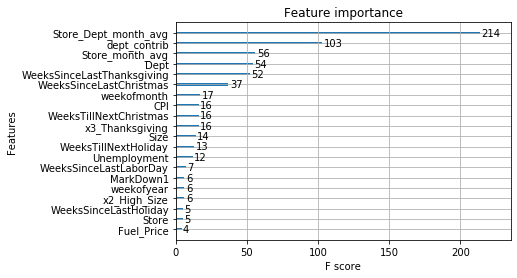

In [42]:
plot_importance(grid_search.best_estimator_,max_num_features=20)

In [ ]:
fig = plt.figure(figsize=(18,9))
plot_importance(grid_search.best_estimator_,max_num_features=20)

In [44]:
res = pd.DataFrame(grid_search.cv_results_)

In [51]:
res.to_csv('major_cv_matrix.csv',index=False)

In [54]:
pd.set_option('display.max_columns', None)

In [56]:
res.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
21,70.796659,33.034700,1.209765,0.179582,0.6,3,3,100,0.7,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3453.705549,3786.400965,2731.064340,2300.069472,3067.810082,584.831494,1,2463.674329,2906.585220,2919.913145,2788.480055,2769.663187,183.919785
41,70.189534,32.522656,1.188074,0.097029,0.6,3,5,100,0.7,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3466.191857,3807.483356,2722.346910,2273.196003,3067.304531,603.444261,2,2457.094219,2896.327430,2913.958253,2772.951919,2760.082955,183.172015
2,68.648904,32.772164,1.253649,0.331235,0.6,3,1,100,0.8,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3436.000366,3803.676338,2747.516683,2268.082861,3063.819062,595.640623,3,2452.734301,2909.440109,2919.831258,2748.569005,2757.643668,188.678990
1,69.095681,31.093743,1.341912,0.193691,0.6,3,1,100,0.7,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3427.294449,3826.293048,2700.852889,2283.138368,3059.394689,603.035949,4,2456.991631,2891.635826,2898.607760,2762.701394,2752.484153,178.980110
43,69.230599,32.511626,1.153417,0.198299,0.6,3,5,100,0.9,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3469.736980,3800.766115,2699.820972,2266.397275,3059.180335,607.484642,5,2440.891353,2931.564672,2911.613529,2776.389339,2765.114723,196.478623
22,70.399223,32.576750,1.042462,0.143040,0.6,3,3,100,0.8,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3437.029692,3797.500057,2732.765441,2259.912073,3056.801816,598.590001,6,2443.368435,2927.340492,2920.083817,2765.905636,2764.174595,196.118831
23,69.364989,32.022175,1.160648,0.069024,0.6,3,3,100,0.9,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3482.272810,3745.792180,2712.211537,2274.193687,3053.617553,588.835859,7,2451.368933,2912.507005,2892.667408,2763.048018,2754.897841,184.402634
20,70.888916,33.640239,1.126239,0.233268,0.6,3,3,100,0.6,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3460.409477,3798.368541,2690.080972,2247.212839,3049.017957,612.881817,8,2447.018249,2951.555130,2878.796976,2752.985568,2757.588981,192.866285
3,68.228527,31.811682,1.059417,0.148123,0.6,3,1,100,0.9,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3462.663185,3793.849773,2686.077118,2251.562210,3048.538071,611.051882,9,2434.079833,2920.366791,2896.060772,2757.784577,2752.072993,193.783097
42,69.719042,31.971125,1.347147,0.233660,0.6,3,5,100,0.8,"{'colsample_bytree': 0.6, 'max_depth': 3, 'min...",3430.695868,3781.233948,2695.567237,2283.725524,3047.805644,590.002612,10,2435.313044,2912.761296,2887.972797,2768.618822,2751.166490,190.326581


col_sample_bytree=0.9
max_depth = 7
min_child_weight = 1
n_estimators = 500
subsample = 0.9

In [ ]:
feats = [feat[0] for feat in sorted(grid_search.best_estimator_.get_booster().get_score().items(), key=itemgetter(1),reverse=True)[:20]]

In [ ]:
feats.append('IsHoliday')

In [ ]:
feats

In [35]:
param_test5 = {
 'max_depth':[7],
 'min_child_weight':[1],
 'subsample':[0.9],
 'colsample_bytree':[0.9],
 'n_estimators':[500]
}

xgb_reg = XGBRegressor(
 learning_rate =0.1,
 gamma=0,
 n_jobs=-1)

grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_test5,
                           scoring=custom_loss_scorer,
                           cv=TimeSeriesSplit(n_splits=4),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_sales,weekly_sales,sample_weights = np.where(X_sales.IsHoliday==True,5,1))
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s


TypeError: fit() got an unexpected keyword argument 'sample_weights'

In [37]:
col_sample_bytree=0.9
max_depth = 7
min_child_weight = 1
n_estimators = 500
subsample = 0.9

In [45]:
?XGBRegressor.fit
X_sales.drop('Date',axis=1,inplace=True)

In [46]:
model_31_oct = XGBRegressor(max_depth=7,
                            col_sample_bytree=0.9,
                            min_child_weight=1,
                            n_estimators=500,
                            subsample=0.9,
                            learning_rate=0.1,
                            gamma=0,
                            n_jobs=-1)

model_31_oct.fit(X_sales,weekly_sales,sample_weight=np.where(X_sales.IsHoliday==True,5,1))

C:\Users\shahb\AnacondaPython\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\shahb\AnacondaPython\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:55:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', col_sample_bytree=0.9,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       gamma=0, importance_type='gain', learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.9, verbosity=1)

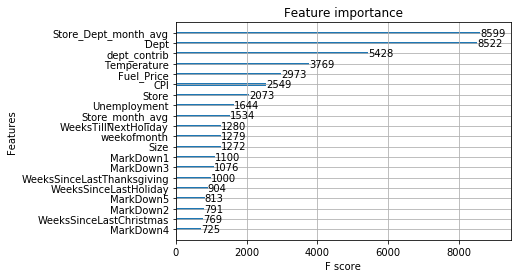

In [59]:
plot_importance(grid_search.best_estimator_,max_num_features=20)

In [4]:
grid_search.cv_results_

NameError: name 'grid_search' is not defined

In [ ]:
test_d.drop('Date',axis=1,inplace=True)

In [ ]:
test_d.head()

In [ ]:
param_test6 = {
 'max_depth':[3],
 'min_child_weight':[5],
 'subsample':[0.9],
 'colsample_bytree':[0.7],
 'n_estimators':[10]
}

xgb_reg = XGBRegressor(
 learning_rate =0.1,
 gamma=0,
 n_jobs=-1)

grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_test6,
                           scoring=custom_loss_scorer,
                           cv=TimeSeriesSplit(n_splits=4),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_sales,weekly_sales)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

In [ ]:
pred_small_test = grid_search.best_estimator_.predict(test_d)

In [ ]:
test_d['pred_small'] = pred_small_test

In [ ]:
test_d['Date']=test.Date

In [ ]:
(min(test_d.Date)-max(test_d.Date))//7

In [ ]:
X_lag_sales['Date']=train.Date
X_lag_sales['Weekly_sales']=weekly_sales
tr_1_1 = get_store(X_lag_sales,1,1)
te_1_1 = get_store(test_d,1,1)

In [ ]:
tr_1_1

In [ ]:
len(tr_1_1['Weekly_sales'][-39:,])

In [ ]:
te_1_1['Weekly_sale(t-1)']=tr_1_1['Weekly_sales'][-39:,]

In [ ]:
te_1_1

In [ ]:
all_test_preds = grid_search.best_estimator_.predict(test_data)
train_preds = grid_search.best_estimator_.predict(train_data)

In [ ]:
train_copy = train_data.copy()
train_copy['preds'] = train_preds
train_copy['Date'] = train['Date']
train_copy['Weekly_Sales'] = train['Weekly_Sales']
t_1_1 = train_copy[(train_copy.Store==1) & (train_copy.Dept==1)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['preds','Weekly_Sales']])

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
all_test_preds = grid_search.best_estimator_.predict(test_data)
train_preds = grid_search.best_estimator_.predict(train_data)

In [ ]:
all_test_preds = grid_search.best_estimator_.predict(test_data[imp_features])
train_preds = grid_search.best_estimator_.predict(train_data[imp_features])
train_copy = train_data.copy()
train_copy['preds'] = train_preds
train_copy['Date'] = train['Date']
train_copy['Weekly_Sales'] = train['Weekly_Sales']
train_copy['log_sales'] = np.log(train_copy.Weekly_Sales)
train_copy['log_preds'] = np.log(train_copy.preds)
t_1_1 = train_copy[(train_copy.Store==1) & (train_copy.Dept==1)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['log_preds','log_sales']])

In [ ]:
grid_search.best_params_

In [ ]:
imp_features = []
c=0
for j in iter(grid_search.best_estimator_.get_booster().get_score()):
    imp_features.append(j)
    c+=1
    if c==10:
        break

In [ ]:
imp_features = ['Dept','Size','Store','Markdown3','CPI']

In [ ]:
X[imp_features].head()

In [ ]:
reduced_X = X[imp_features]
len(reduced_X)
pos_weekly_sales_ind = weekly_sales>0
len(reduced_X[pos_weekly_sales_ind])

In [ ]:
?cross_val_score

In [ ]:
model = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 subsample=0.9,
 colsample_bytree=0.7,
 gamma=0,
 n_jobs=-1,verbosity=3)

results = cross_val_score(model, X_sales, weekly_sales, cv=TimeSeriesSplit(n_splits=5), scoring=custom_loss_scorer, n_jobs=-1)

In [ ]:
?results

In [ ]:
def make_predictions(model,train,Date,y,log=False):
    train_preds = model.predict(train)
    train_copy = train.copy()
    train_copy['preds'] = train_preds
    train_copy['Date'] = Date
    train_copy['Weekly_Sales'] = y
    
    weight_array = np.where(train_copy.IsHoliday==True,5,1)
    error = np.mean(weight_array*(np.abs(y-train_preds)))
    
    return error,train_copy

In [ ]:
e,t = make_predictions(grid_search.best_estimator_,X_sales,train.Date,y=weekly_sales)

In [ ]:
e

In [ ]:
t.head()

In [ ]:
t_1_1 = get_store(t,1,1)
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['preds','Weekly_Sales']])

In [ ]:
param_test4 = {
 'subsample':[0.9],
 'colsample_bytree':[0.7]
}

xgb_reg = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 n_jobs=-1)

grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_test4,
                           scoring=custom_loss_scorer,
                           cv=TimeSeriesSplit(n_splits=5),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_sales,weekly_sales)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
?TimeSeriesSplit

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
#all_test_preds = grid_search.best_estimator_.predict(test_data)
train_preds = grid_search.best_estimator_.predict(X_sales)
train_copy = train_data.copy()
train_copy['preds'] = (train_preds)
train_copy['Date'] = train['Date']
train_copy['Weekly_Sales'] = weekly_sales
t_1_1 = train_copy[(train_copy.Store==2) & (train_copy.Dept==10)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['preds','Weekly_Sales']])

In [ ]:
plot_importance(grid_search.best_estimator_,max_num_features=10)

In [ ]:
def custom_loss_scorer_log(estimator,X,y):
    weight_array = np.where(X.IsHoliday==True,5,1)
    preds = estimator.predict(X)
    error = np.mean(weight_array*np.abs(np.exp(y)-np.exp(preds)))
    
    return error

#weight = reduced_X[pos_weekly_sales_ind].IsHoliday==True,5,1
custom_loss_scorer_log(grid_search.best_estimator_,reduced_X[pos_weekly_sales_ind],np.log(weekly_sales[pos_weekly_sales_ind]))

In [ ]:
all_test_preds = grid_search.best_estimator_.predict(test_data[imp_features])
train_preds = grid_search.best_estimator_.predict(train_data[imp_features])
train_copy = train_data.copy()
train_copy['preds'] = np.exp(train_preds)
train_copy['Date'] = train['Date']
train_copy['Weekly_Sales'] = weekly_sales[pos_weekly_sales_ind]
t_1_1 = train_copy[(train_copy.Store==2) & (train_copy.Dept==10)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['preds','Weekly_Sales']])
for i in range(len(holiday_dates)):
    plt.axvline(holiday_dates[i],color='red')

In [ ]:
t_1_1 = train_copy[(train_copy.Store==1) & (train_copy.Dept==3)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1.preds-t_1_1.Weekly_Sales,color='red')
sns.lineplot(data=t_1_1[['preds','Weekly_Sales']])
t_1_1

In [62]:
all_test_preds = grid_search.best_estimator_.predict(test_d)
test_output = test_data.copy()
test_output['preds'] = all_test_preds
test_output['id'] = test_output['Store'].astype(int).astype(str) + '_' +  test_output['Dept'].astype(int).astype(str) + '_' +  test['Date'].astype(str)
test_output = test_output[['id', 'preds']]
test_output = test_output.rename(columns={'id': 'Id', 'preds': 'Weekly_Sales'})

test_output.to_csv('output.csv', index=False)

In [ ]:
test_d.head()

In [ ]:
test_output.head()

In [61]:
test_d.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,WeeksTillNextHoliday,WeeksSinceLastHoliday,WeeksTillNextSuperBowl,WeeksSinceLastSuperBowl,WeeksTillLaborDay,WeeksSinceLastLaborDay,WeeksTillNextThanksgiving,WeeksSinceLastThanksgiving,WeeksTillNextChristmas,WeeksSinceLastChristmas,x0_A,x0_B,x0_C,x1_HighCPI,x1_LowCPI,x2_High_Size,x2_Mid_Size,x2_Small_Size,x3_Christmas,x3_Labor_Day,x3_NoHoliday,x3_Super_Bowl,x3_Thanksgiving,quarter,month,year,weekofyear,weekofmonth,Store_Dept_month_avg,Store_month_avg,dept_contrib
0,1.0,1.0,False,151315.0,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,8.0,3.0,38.0,14.0,8.0,44.0,49.0,3.0,44.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4,11,2012,44,1,23837.36375,23097.785277,1.032019
1,1.0,1.0,False,151315.0,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,9.0,2.0,39.0,13.0,9.0,43.0,50.0,2.0,45.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4,11,2012,45,2,23837.36375,23097.785277,1.032019
2,1.0,1.0,False,151315.0,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,10.0,1.0,40.0,12.0,10.0,42.0,51.0,1.0,46.0,6.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4,11,2012,46,3,23837.36375,23097.785277,1.032019
3,1.0,1.0,True,151315.0,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,0.0,0.0,41.0,11.0,11.0,41.0,0.0,0.0,47.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4,11,2012,47,4,23837.36375,23097.785277,1.032019
4,1.0,1.0,False,151315.0,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,1.0,4.0,42.0,10.0,12.0,40.0,1.0,52.0,48.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4,11,2012,48,5,23837.36375,23097.785277,1.032019
